In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

from library.sb_utils import save_file



The dataset was too large to upload in one go, so it was manually split up into two similiarly sized json files.  Then read into two different data frame and ultimately merged into one data frame.

In [2]:
#first dataset

with open('trans1.json','r') as f1:
    d1= (line.strip() for line in f1)
    d_json1="[{0}]".format(','.join(d1))
    
data1 = pd.read_json(d_json1)
print("1st data's shape:",data1.shape)

#second dataset

with open('trans2.json','r') as f2:
    d2= (line.strip() for line in f2)
    d_json2="[{0}]".format(','.join(d2))

data2=pd.read_json(d_json2)
print("2nd data's shape:",data2.shape)


#merge the two into df
    
df= pd.merge(data1,data2,how='outer')

print("final merged data's shape:",df.shape)

1st data's shape: (391085, 29)
2nd data's shape: (395278, 29)
final merged data's shape: (786363, 29)


In [3]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


Info shows no null entries, but there are clearly are some null/empty entries

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [5]:
#replace empty spaces with NaN values

df = df.replace('',np.nan, regex=True)

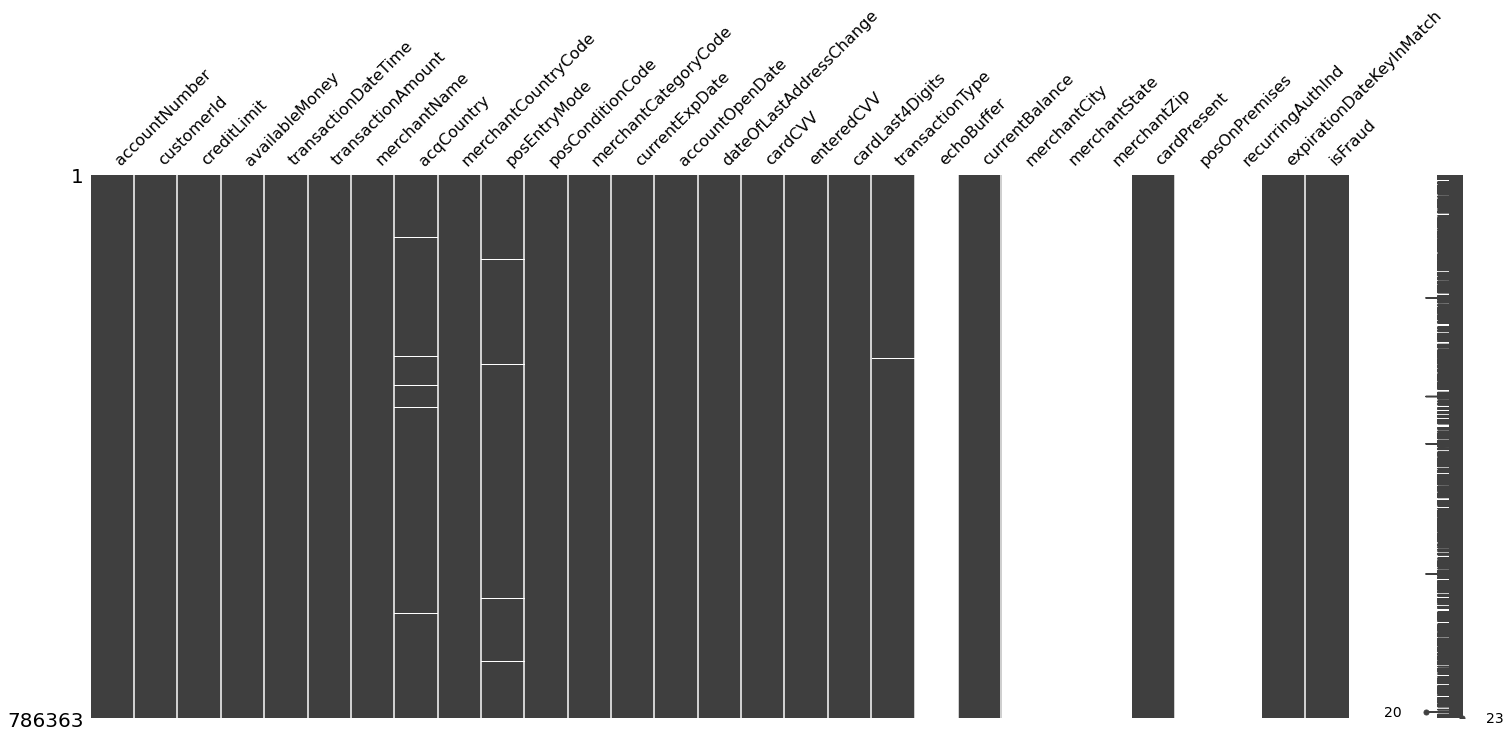

In [6]:
#Look at the whitespaces for null entries for each feature

msno.matrix(df)

In [7]:
#Create a dataframe for entries with null values

columns_null = pd.DataFrame({'na_count':df.isnull().sum()})
columns_null['percent']=round(columns_null['na_count']/len(df)*100,2)
columns_null.sort_values(by='percent',ascending=False)

,na_count,percent
recurringAuthInd,786363,100.00
posOnPremises,786363,100.00
merchantZip,786363,100.00
merchantState,786363,100.00
merchantCity,786363,100.00
echoBuffer,786363,100.00
acqCountry,4562,0.58
posEntryMode,4054,0.52
merchantCountryCode,724,0.09
transactionType,698,0.09


There are 6 features with completely null entries, then five features contain null entries that are of less than 1% of the whole feature.  Dropping such a small amount will have no affect on overall model performance.

In [8]:
#drop all features with all null entries, then drop all other transactions that contain null values

df=df.drop(columns=['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'])

df.dropna(inplace=True)

accountNumer and customerId looks very similiar.  If they are the same, drop one 

In [9]:
#they are exactly the same

sum(df.accountNumber!=df.customerId)

0

In [10]:
#drop accountNumber

df.drop(columns='accountNumber',inplace=True)

In [11]:
#Check for duplicated rows

df.duplicated().sum()

0

# acqCountry and merchantCountryCode

In [12]:
#acqCountry and merchantCountryCode appears to be the same, but there are 67 instances where they do not match

sum(df.acqCountry.values!=df.merchantCountryCode)

67

In [13]:
#subset where acqCountry does not match with merchantCountryCode

acq_not_merch = df[df.acqCountry.values!=df.merchantCountryCode][['customerId','acqCountry','merchantCountryCode','isFraud']]
acq_not_merch.head()

,customerId,acqCountry,merchantCountryCode,isFraud
523,984504651,US,PR,False
12629,593440936,CAN,US,False
34624,657326011,US,CAN,False
58521,246251253,CAN,US,False
61725,445843699,US,MEX,False


In [14]:
#this umatching does not seem to affect or cause fraud

sum(acq_not_merch.isFraud)

0

In [15]:
#

nonmatch_df = pd.DataFrame(acq_not_merch.customerId.value_counts()).rename(columns={'customerId':'Count'})

a = {}

for i in nonmatch_df.index:
    b = len(df[df.customerId==i])
    a[i]=b
    
nonmatch_df2=pd.DataFrame(a,index=['Total_Transactions']).T


nonmatch_df = nonmatch_df.merge(nonmatch_df2,left_index=True,right_index=True)
nonmatch_df['Perc']= round(nonmatch_df.Count/nonmatch_df.Total_Transactions*100,3)


Most entries where acqCountry does not match merchantCountryCode contain less than 1% of each customer's transaction,
except one customer where they have the highest unmatchings and also the highest percentage.\
Also, the total amount of unmatches is very little compared to the whole data.

In [16]:
print('Percentage of total unmatching: ' + str(round(len(nonmatch_df)/len(df)*100,4))+' %')
nonmatch_df

Percentage of total unmatching: 0.0064 %


,Count,Total_Transactions,Perc
272804274,12,63,19.048
380680241,3,32467,0.009
964624120,2,275,0.727
445843699,2,1210,0.165
240360270,2,282,0.709
283694178,2,1485,0.135
865635967,1,1262,0.079
373215405,1,156,0.641
375252798,1,1411,0.071
657326011,1,1120,0.089


In [17]:
#look more into customerId, 272804274

cust1 = df[df.customerId==272804274]
cust1

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
496555,272804274,20000,20000.00,2016-01-11T17:41:15,5.66,cheapfast.com,US,US,05,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,0.00,False,False,False
496556,272804274,20000,19994.34,2016-01-18T06:42:06,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,5.66,False,False,False
496557,272804274,20000,20000.00,2016-02-18T17:56:05,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,0.00,False,False,False
496558,272804274,20000,20000.00,2016-03-01T09:54:21,202.36,Subway #105984,US,US,05,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,0.00,True,False,False
496559,272804274,20000,19797.64,2016-03-06T22:28:24,170.87,oldnavy.com,US,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,202.36,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496613,272804274,20000,19282.05,2016-12-12T04:33:36,45.46,Sunoco Gas #403204,US,US,09,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,717.95,True,False,False
496614,272804274,20000,19236.59,2016-12-18T23:50:33,7.81,Play Store,US,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,763.41,False,False,False
496615,272804274,20000,19228.78,2016-12-25T02:38:02,68.94,target.com,US,US,09,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,771.22,False,False,False
496616,272804274,20000,19159.84,2016-12-25T05:50:19,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,840.16,False,False,False


In [18]:
# This appears to only be happening with the merchant abc.com

cust1_abc = cust1[cust1.acqCountry!=cust1.merchantCountryCode]
cust1_abc

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
496556,272804274,20000,19994.34,2016-01-18T06:42:06,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,5.66,False,False,False
496557,272804274,20000,20000.00,2016-02-18T17:56:05,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,0.00,False,False,False
496562,272804274,20000,19364.97,2016-03-20T11:08:04,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,635.03,False,False,False
496569,272804274,20000,19611.59,2016-04-20T19:52:45,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,388.41,False,False,False
496577,272804274,20000,19704.49,2016-05-22T11:52:30,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,295.51,False,False,False
496581,272804274,20000,19946.73,2016-06-22T09:28:46,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,53.27,False,False,False
496588,272804274,20000,19937.94,2016-07-23T11:02:45,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,62.06,False,False,False
496593,272804274,20000,19897.31,2016-08-23T18:13:37,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,102.69,False,False,False
496597,272804274,20000,19891.77,2016-09-24T00:41:40,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,108.23,False,False,False
496603,272804274,20000,19872.62,2016-10-25T18:58:48,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,127.38,False,False,False


In [19]:
#Take a look at all of abc.com transaction

abc = df[df.merchantName=='abc.com']
abc

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
1647,239577603,5000,1329.10,2016-07-12T15:59:14,13.86,abc.com,US,US,02,01,...,2015-08-12,2015-08-12,808,808,3135,PURCHASE,3670.90,False,False,False
1650,239577603,5000,1017.00,2016-08-13T14:23:06,13.86,abc.com,US,US,02,01,...,2015-08-12,2015-08-12,808,808,3135,PURCHASE,3983.00,False,False,False
1653,239577603,5000,809.16,2016-09-13T22:29:49,13.86,abc.com,US,US,02,01,...,2015-08-12,2015-08-12,808,808,3135,PURCHASE,4190.84,False,False,False
1657,239577603,5000,520.50,2016-10-15T11:41:47,13.86,abc.com,US,US,02,01,...,2015-08-12,2015-08-12,808,808,3135,PURCHASE,4479.50,False,False,False
1664,239577603,5000,1130.61,2016-11-15T09:40:37,13.86,abc.com,US,US,02,01,...,2015-08-12,2015-08-12,808,808,3135,PURCHASE,3869.39,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785887,428856030,250,77.76,2016-08-22T23:12:59,15.82,abc.com,US,US,05,01,...,2009-08-17,2009-08-17,990,990,7660,PURCHASE,172.24,False,False,False
785900,428856030,250,102.23,2016-09-23T06:11:26,15.82,abc.com,US,US,05,01,...,2009-08-17,2009-08-17,990,990,7660,PURCHASE,147.77,False,False,False
785911,428856030,250,202.37,2016-10-24T18:10:07,15.82,abc.com,US,US,05,01,...,2009-08-17,2009-08-17,990,990,7660,PURCHASE,47.63,False,False,False
785920,428856030,250,114.11,2016-11-25T14:42:38,15.82,abc.com,US,US,05,01,...,2009-08-17,2009-08-17,990,990,7660,PURCHASE,135.89,False,False,False


In [20]:
#It appears out of 2,851 transactions with abc.com, only 12 does not match and they all belong to the same customer. 

abc[abc.acqCountry!=abc.merchantCountryCode]

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
496556,272804274,20000,19994.34,2016-01-18T06:42:06,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,5.66,False,False,False
496557,272804274,20000,20000.00,2016-02-18T17:56:05,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,0.00,False,False,False
496562,272804274,20000,19364.97,2016-03-20T11:08:04,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,635.03,False,False,False
496569,272804274,20000,19611.59,2016-04-20T19:52:45,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,388.41,False,False,False
496577,272804274,20000,19704.49,2016-05-22T11:52:30,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,295.51,False,False,False
496581,272804274,20000,19946.73,2016-06-22T09:28:46,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,53.27,False,False,False
496588,272804274,20000,19937.94,2016-07-23T11:02:45,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,62.06,False,False,False
496593,272804274,20000,19897.31,2016-08-23T18:13:37,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,102.69,False,False,False
496597,272804274,20000,19891.77,2016-09-24T00:41:40,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,108.23,False,False,False
496603,272804274,20000,19872.62,2016-10-25T18:58:48,19.41,abc.com,MEX,US,02,01,...,2014-03-01,2014-03-01,228,228,1010,PURCHASE,127.38,False,False,False


In [26]:
print(cust1.acqCountry.value_counts())
print(cust1.merchantCountryCode.value_counts())

US     51
MEX    12
Name: acqCountry, dtype: int64
US    63
Name: merchantCountryCode, dtype: int64


All values of acqCountry and merchantCountryCode for customer 272804274 is either US or MEX,
but 12 does not match each other.  Those 12 contain the only values of MEX for that customer.  This might be an entry error. 
Replace MEX with US

In [27]:
rows = cust1_abc.index

df.loc[rows,'acqCountry'] = df[df.customerId==272804274]['acqCountry'].str.replace('MEX','US')

print(df[df.customerId==272804274].acqCountry.unique())
print(df[df.customerId==272804274].merchantCountryCode.unique())

['US']
['US']


# Do the same with the other unmatches or drop?  

The other 49 customers that have unmatching entries contain about or less than 1% of their total data 

Having these two features match or not does not affect fraudulent cases

So drop them and as it will not have much impact on the model later

In [31]:
df[df['acqCountry']!=df['merchantCountryCode']]['isFraud'].sum()

0

In [32]:
# Drop all entries where acqCountry does not match merchantCountryCode

rows_to_drop = df[df['acqCountry']!=df['merchantCountryCode']].index

df = df.drop(rows_to_drop)

print(df.shape)

(776613, 22)


In [33]:
#Now that acqCountry and merchantCuntryCode are exactly the same, drop one

df=df.drop(columns=['merchantCountryCode'])
print(df.shape)

(776613, 21)


The actual card VV is not important, what's more important is if the entered CVV matches.  So create a new feature where 0 if it matches and 1 if it doesn't.  Then drop the other two columns.

In [34]:
df['Incorrect CVV Entered']= np.where(df.cardCVV==df.enteredCVV,0,1)
df=df.drop(columns = ['cardCVV','enteredCVV'])

In [35]:
# Change the bool Dtypes to int64 by changing false to 0 and true to 1

df['cardPresent']=df['cardPresent'].replace([False,True],[0,1])
df['expirationDateKeyInMatch']=df['expirationDateKeyInMatch'].replace([False,True],[0,1])
df['isFraud']=df['isFraud'].replace([False,True],[0,1])

# What next?

Dive further into each feature and explore the varaiances between fraud and non-fraudulent activities.  

In [36]:
datapath = '../CC_Fraud'
save_file(df, 'Cleaned.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../CC_Fraud\Cleaned.csv"
